### Load Dependencies

In [16]:
import swisseph as swe
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
from calc import find_new_moon_conjunctions
from scipy.signal import argrelextrema

# configure ephemeris
swe.set_ephe_path('./ephe')

# https://ssd.jpl.nasa.gov/planets/eph_export.html
# Created April 2013; includes librations and 1980 nutation.
# Referred to the International Celestial Reference Frame  version 2.0.
# Covers JED -3100015.5, (-13200 AUG 15) to JED 8000016.5,(17191 MAR 15).
swe.set_jpl_file('DE431.eph')

weekname = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]

### Configure Script

In [85]:
# YEAR_START = -11084
YEAR_START = 1000
YEAR_END = 2024
# MY_GEO_LOC = [-122.258301, 37.801239, 13]  # Oakland, CA

### Calculate Solar Equinox / Lunar Phase Dataset

In [86]:
# INITIALIZE VARIABLES
nm = []
first_eq = None
prev_eq = None
moon_year = 0
moon_day = 0
moon_total_days = 0
total_lunar_year_days = 0

# Get Equinox / New Moons for year prior tor YEAR_START
eq = swe.solcross_ut(x2cross=0,tjdut=swe.julday(YEAR_START-1, 1, 1))
next_eq = swe.solcross_ut(x2cross=0,tjdut=swe.julday(YEAR_START, 1, 1))
last_nm = find_new_moon_conjunctions(swe, eq, next_eq)[-1]
for jyear in range(YEAR_START, YEAR_END):
    jd = swe.julday(jyear, 1, 1)
    
    # get vernal equinox for this year
    eq = swe.solcross_ut(
        x2cross=0,
        tjdut=jd
    )
    
    # get vernal equinox for next year
    next_eq = swe.solcross_ut(
        x2cross=0,
        tjdut=swe.julday(jyear + 1, 1, 1)
    )
        
    # save equinox for YEAR_START to maintain running day count
    first_eq = eq if first_eq is None else first_eq

    # get all new moons in the Lunar year ( all new moons between this and the next vernal equinox )
    # you will get back either 12 or 13 months. 
    nm_conj = find_new_moon_conjunctions(swe, eq, next_eq)
        
    # Calculate the number of days in this lunar year by taking the difference
    # between the last lunar month's new moon date from the first lunar months new moon date.
    lunar_year_num_days = nm_conj[-1] - nm_conj[0]       
    
    eq_str = swe.revjul(eq, swe.GREG_CAL)
    moon_year += 1  
    for idx, m in enumerate(nm_conj):        
        last_day_in_month = m - last_nm
        
        nm.append({
            "ve": eq,     
            "ve_date": f"{eq_str[1]}/{eq_str[2]}/{eq_str[0]}",
            "jd": m,
            "nm_eq": m - eq,
            "sun_year": jyear,
            "lunar_year": moon_year,            
            "lunar_month": idx + 1,
            "lunar_days": last_day_in_month,
            "total_days": moon_total_days + last_day_in_month,
            "day_of_week": swe.day_of_week(eq)            
        })
    moon_total_days += (nm_conj[-1] - last_nm)
    last_nm = nm_conj[-1]

nm_df = pd.DataFrame(nm)

### Find where both the sun and moon cycles reset that matches the 294 year cycle proposed by Enoch
This is important in order to know what year in the 294 year cycle we are in.

First we're going to overlay the dataset with a running 364 day year count and the 294 enoch year count.

In [87]:
# Calculate Enoch 364 Day 
nm_df["eday"] = np.floor(nm_df["total_days"] % 364) + 1 

# Calculate Enoch 294 Year
nm_df["eyear"] = (np.floor((nm_df["total_days"] / 364)) % 294) + 1
nm_df[:13]

,ve,ve_date,jd,nm_eq,sun_year,lunar_year,lunar_month,lunar_days,total_days,day_of_week,eday,eyear
0,2.086381e+06,3/20/1000,2.086405e+06,23.406915,1000,1,1,29.465239,29.465239,3,30.0,1.0
1,2.086381e+06,3/20/1000,2.086434e+06,52.771723,1000,1,2,58.830047,58.830047,3,59.0,1.0
2,2.086381e+06,3/20/1000,2.086464e+06,82.067665,1000,1,3,88.125990,88.125990,3,89.0,1.0
3,2.086381e+06,3/20/1000,2.086493e+06,111.339379,1000,1,4,117.397704,117.397704,3,118.0,1.0
4,2.086381e+06,3/20/1000,2.086522e+06,140.638663,1000,1,5,146.696987,146.696987,3,147.0,1.0
5,2.086381e+06,3/20/1000,2.086551e+06,170.015522,1000,1,6,176.073846,176.073846,3,177.0,1.0
6,2.086381e+06,3/20/1000,2.086581e+06,199.506559,1000,1,7,205.564884,205.564884,3,206.0,1.0
7,2.086381e+06,3/20/1000,2.086611e+06,229.123563,1000,1,8,235.181887,235.181887,3,236.0,1.0
8,2.086381e+06,3/20/1000,2.086640e+06,258.848926,1000,1,9,264.907251,264.907251,3,265.0,1.0
9,2.086381e+06,3/20/1000,2.086670e+06,288.640802,1000,1,10,294.699126,294.699126,3,295.0,1.0


### Next we want to examime the lunar cycle. 
Lets see if we can find a pattern looking at the distance of the first month in the lunar year 
and the start of the vernal equinox. Here we're going to calculate distance between the number of days between
the date of vernal equinox and the date of the first new moon of the lunar year

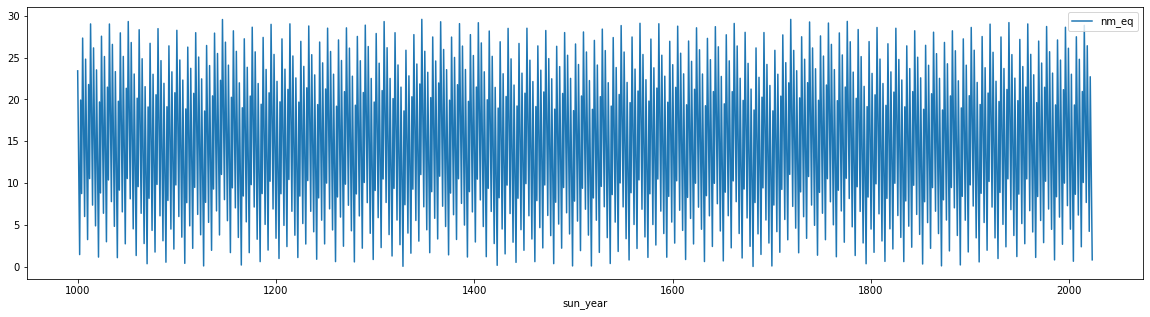

In [88]:
nm_df[nm_df.lunar_month == 1].plot("sun_year", y=["nm_eq"], figsize=[20, 5])

### Finding the Lunar Minor cycle
Looking at the above plot, you can see there are peaks and troughs where the distance between the new moon and the equinox ranges from 0 to 30. Lets see if we can pull out these troughs in this chart by marking in the dataset when these troughs occur.

In [89]:
# Filter all rows where the lunar_month = 1 and closest to the vernal equinox. 
# (this will be used in defining the lunar cycle)
mask = nm_df["lunar_month"] == 1
df = pd.DataFrame(nm_df[mask])
ilocs_min = argrelextrema(df["nm_eq"].values, np.less_equal)[0]  # [::9]

# set the minor lunar cycle based on the above filter
df.loc[df.iloc[ilocs_min].index, "minor_lunar_cycle"] = True
df[df.minor_lunar_cycle == True][:5]

,ve,ve_date,jd,nm_eq,sun_year,lunar_year,lunar_month,lunar_days,total_days,day_of_week,eday,eyear,minor_lunar_cycle
24,2.087112e+06,3/21/1002,2.087113e+06,1.458750,1002,3,1,29.753722,738.005692,6,11.0,3.0,True
49,2.087842e+06,3/20/1004,2.087851e+06,8.749418,1004,5,1,29.583975,1475.780040,1,20.0,5.0,True
86,2.088938e+06,3/21/1007,2.088944e+06,6.009223,1007,8,1,29.365387,2568.763719,5,21.0,8.0,True
123,2.090034e+06,3/21/1010,2.090037e+06,3.251712,1010,11,1,29.694013,3661.737262,2,22.0,11.0,True
148,2.090764e+06,3/20/1012,2.090775e+06,10.538576,1012,13,1,29.694368,4399.507101,4,32.0,13.0,True


Looks like when considering only the dates where the new moon and equinox are the closest. A lunar minor cycle is discovered.
Just like the lunar month can be 29 or 30 days or the lunar year 12 or 13 months. This minor cycle can be either 2 or 3 lunar years.

To better visualize this, we're going to add a running day incrementor between all the points between each of the minor lunar cycles

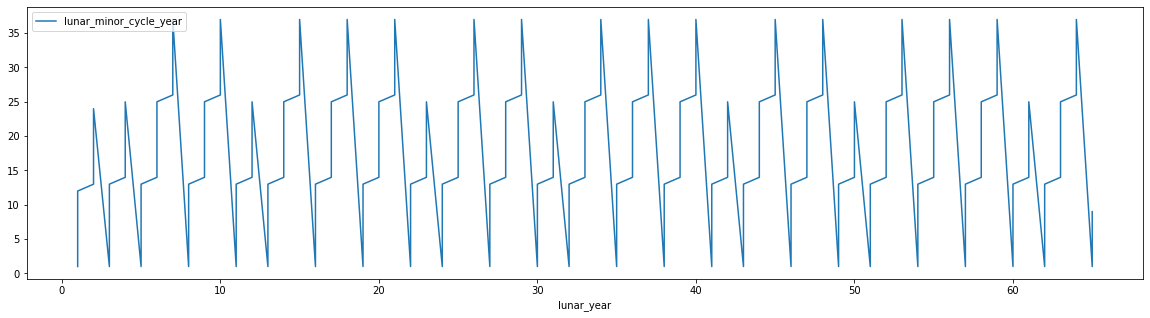

In [98]:
mask = df["minor_lunar_cycle"] == True
nm2 = nm_df.merge(df[mask][["lunar_month", "lunar_year", "minor_lunar_cycle"]], on=["lunar_month", "lunar_year"], how="outer")
nm2['minor_lunar_cycle'] = nm2['minor_lunar_cycle'].fillna(False)

nm2['group'] = nm2['minor_lunar_cycle'].cumsum()
nm2['lunar_minor_cycle_year'] = nm2.groupby('group').cumcount() + 1
nm2.loc[nm2['minor_lunar_cycle'], 'lunar_minor_cycle_year'] = 1
nm2 = nm2.drop(columns=['group'])

nm2[:800].plot("lunar_year", y=["lunar_minor_cycle_year"], figsize=[20, 5])

### Patterns Emerge
Lets see what happens when we overlay the above chart with the 294 year cycle. We're going to zoom
in so we can see if there are any alignments

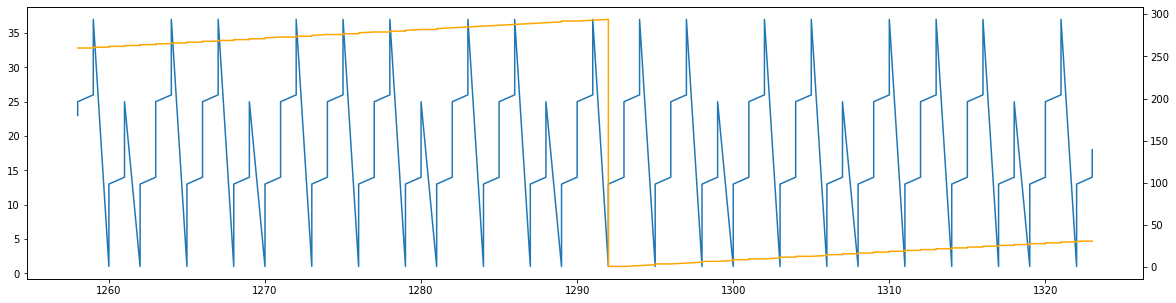

In [99]:
df_filter = nm2[3200:4000]

fig, ax = plt.subplots(figsize=(20, 5))
ax2 = ax.twinx()

ax.plot(df_filter["sun_year"], df_filter["lunar_minor_cycle_year"])
ax2.plot(df_filter["sun_year"], df_filter["eyear"], color="orange")

### Lunar Greater Cycle
Amazingly enough it looks like this minor lunar cycle perfectly aligns with at least this first instance of the 294 year cycle.
Notice how when the 294 year cycle reset, it reset exactly on one of the troughs of this lunar cycle.

Lets take this a bit further, there is another lunar cycle hidden in here which I call the greater lunar cycle. This cycle is a cycle of either 32 or 33 lunar years

In [92]:
mask = df["minor_lunar_cycle"] == True
nm2 = nm_df.merge(df[mask][["lunar_month", "lunar_year", "minor_lunar_cycle"]], on=["lunar_month", "lunar_year"], how="outer")
nm2['minor_lunar_cycle'] = nm2['minor_lunar_cycle'].fillna(False)
phoenix_cycle = nm2[nm2["minor_lunar_cycle"] == True][::12].index
nm2.loc[nm2.iloc[phoenix_cycle].index, "new_phoenix_cycle"] = True
nm2['new_phoenix_cycle'] = nm2['new_phoenix_cycle'].fillna(False)

nm2['group'] = nm2['new_phoenix_cycle'].cumsum()
nm2['lunar_cycle_year'] = nm2.groupby('group').cumcount() + 1
nm2.loc[nm2['new_phoenix_cycle'], 'lunar_cycle_year'] = 1

nm2 = nm2.drop(columns=['group', 'new_phoenix_cycle', 'minor_lunar_cycle'])
nm_df = nm2

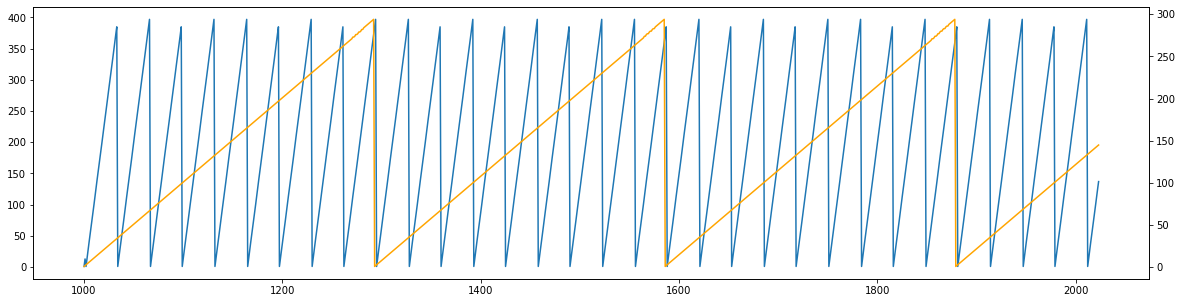

In [114]:
df_filter = nm_df[nm_df.lunar_month == 1]

fig, ax = plt.subplots(figsize=(20, 5))
ax2 = ax.twinx()

ax.plot(df_filter["sun_year"], df_filter["lunar_cycle_year"])
ax2.plot(df_filter["sun_year"], df_filter["eyear"], color="orange")

In [107]:
nm_df[(nm_df.lunar_month == 1) & (nm_df.eyear == 1)]

,ve,ve_date,jd,nm_eq,sun_year,lunar_year,lunar_month,lunar_days,total_days,day_of_week,eday,eyear,lunar_cycle_year
0,2.086381e+06,3/20/1000,2.086405e+06,23.406915,1000,1,1,29.465239,29.465239,3,30.0,1.0,1
3624,2.193397e+06,3/19/1293,2.193424e+06,26.311108,1293,294,1,29.574158,107048.375538,3,33.0,1.0,385
7248,2.300413e+06,3/20/1586,2.300443e+06,29.033913,1586,587,1,29.702823,214067.098322,3,36.0,1.0,373
10871,2.407429e+06,3/20/1879,2.407431e+06,1.897816,1879,880,1,29.709307,321055.969100,3,8.0,1.0,372


# Close but not the cigar
So far it looks like we got it. An amazing coincidence or did our ancestors know a little something about astronomy.
But let dig in to this a bit more. It's hard to see if the alignment is perfect because in the above chart we're looking at around 1000 years. Lets zoom in to right where the alignment occurs and see if it's perfect or not.


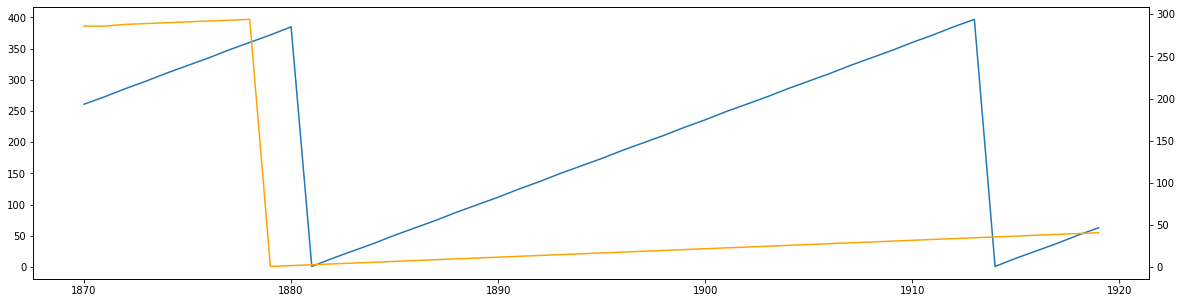

In [135]:
df_filter = nm_df[nm_df.lunar_month == 1][270:320]
df_filter = nm_df[nm_df.lunar_month == 1][570:620]
df_filter = nm_df[nm_df.lunar_month == 1][870:920]


fig, ax = plt.subplots(figsize=(20, 5))
ax2 = ax.twinx()

ax.plot(df_filter["sun_year"], df_filter["lunar_cycle_year"])
ax2.plot(df_filter["sun_year"], df_filter["eyear"], color="orange")

# Off by 2 Lunar months.
zooming in to each of the troughs where the 294 year cycle begins, we can see that the greater lunar cycle is off by what appears exactly 2 months.
This is an example of one of when the 294 year cycle begins, but after investigating each of these cycles, it seems it's always off by exactly 2 months.

In [124]:
nm_df[nm_df.lunar_month == 1][290:298]

,ve,ve_date,jd,nm_eq,sun_year,lunar_year,lunar_month,lunar_days,total_days,day_of_week,eday,eyear,lunar_cycle_year
3587,2.192302e+06,3/20/1290,2.192331e+06,28.867401,1290,291,1,29.353546,105955.200587,0,32.0,292.0,348
3599,2.192667e+06,3/20/1291,2.192685e+06,18.325148,1291,292,1,29.396869,106309.901611,1,22.0,293.0,360
3611,2.193032e+06,3/19/1292,2.193040e+06,7.665284,1292,293,1,29.534128,106664.489463,2,13.0,294.0,372
3624,2.193397e+06,3/19/1293,2.193424e+06,26.311108,1293,294,1,29.574158,107048.375538,3,33.0,1.0,385
3636,2.193763e+06,3/20/1294,2.193778e+06,15.242620,1294,295,1,29.710905,107402.549519,5,23.0,2.0,397
3648,2.194128e+06,3/20/1295,2.194132e+06,4.002576,1295,296,1,29.691412,107756.549713,6,13.0,3.0,1
3661,2.194493e+06,3/19/1296,2.194516e+06,22.496931,1296,297,1,29.601340,108140.284262,0,33.0,4.0,14
3673,2.194858e+06,3/19/1297,2.194870e+06,11.541792,1297,298,1,29.464201,108494.574212,1,23.0,5.0,26
